## Import Packages

In [1]:
from data import shortestpath, dataset
from model import shortestPathModel
from func import blackboxOpt
from evalm import unambSPO

In [2]:
import time
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.utils.data import DataLoader

## Build Model 

In [3]:
# model for shortest path
grid = (5,5)
sp_model = shortestPathModel(grid)

Academic license - for non-commercial use only - expires 2021-06-13
Using license file C:\Users\Apocrypse\gurobi.lic


## Training

In [4]:
# build linear model
class LinearRegression(nn.Module):
    
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(p, (grid[0] - 1) * grid[1] + (grid[1] - 1) * grid[0])
    
    def forward(self, x):
        out = self.linear(x)
        return out

In [5]:
def train(dataloader, opt_model, num_epochs, learning_rate, lambd=20, l1_lambda=1e-3):
    """
    train model with Black-Box Optimizer
    args:
      dataloader: dataloader from optDataSet
      model: optModel
      num_epochs: number of epochs
      lambda: black-box optimizer parameter
    """
    print('Training...')
    # init model
    lr = LinearRegression()
    # cuda
    if torch.cuda.is_available():
        lr = lr.cuda()
    # training mode
    lr.train()
    # set optimizer
    optimizer = torch.optim.SGD(lr.parameters(), lr=learning_rate)
    # set loss
    criterion = nn.L1Loss()
    # train
    time.sleep(1)
    for epoch in tqdm(range(num_epochs)):
        # load data
        for i, data in enumerate(dataloader):
            x, c, w, z = data
            # cuda
            if torch.cuda.is_available():
                x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
            # linear regression
            cp = lr(x)
            # black-box optimizer
            wp = blackboxOpt.apply(opt_model, cp, lambd)
            # objective value
            zp = (wp * c).sum(1).view(-1, 1)
            # l1 loss
            loss = criterion(zp, z)
            # l1 reg
            l1_reg = torch.abs(cp - c).sum(dim=1).mean()
            loss += l1_lambda * l1_reg
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return lr

## Experiments

### Training Set Size = 100, Noise Half−width = 0

In [6]:
# set up
n = 100 # number of data
p = 5 # size of feature
e = 0 # noise half−width
degs = [1, 2, 4, 6] # list of param deg

In [7]:
# init DataFrame
df1 = pd.DataFrame(columns = degs)

In [8]:
for i in range(8):
    row = {}
    for deg in degs:
        # generate data
        x, c = shortestpath.genData(n+1000, p, grid, deg=deg, noise_width=e, seed=i)
        # data split
        x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=i)
        # build data set
        sp_dataset_train = dataset.optDataset(sp_model, x_train, c_train)
        sp_dataset_test = dataset.optDataset(sp_model, x_test, c_test)
        # get data loader
        batch_size = 32
        sp_loader_train = DataLoader(sp_dataset_train, batch_size=batch_size, shuffle=True)
        sp_loader_test = DataLoader(sp_dataset_test, batch_size=batch_size, shuffle=False)
        # train
        learning_rate = 1e-1
        num_epochs = 100
        lr = train(sp_loader_train, sp_model, num_epochs=num_epochs, learning_rate=learning_rate, l1_lambda=1e-3)
        # eval
        loss = unambSPO(lr, sp_model, sp_loader_test)
        print('Normalized SPO Loss: {:.2f}%'.format(loss * 100))
        row[deg] = loss
        print()
    df1 = df1.append(row, ignore_index = True)

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 261.08it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 267.22it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:08<00:00,  1.46it/s]


Normalized SPO Loss: 0.55%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 437.85it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 396.93it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:00<00:00,  1.66it/s]


Normalized SPO Loss: 3.03%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 356.82it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 348.44it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:53<00:00,  1.88it/s]


Normalized SPO Loss: 3.94%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 376.94it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 293.80it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:58<00:00,  1.72it/s]


Normalized SPO Loss: 21.38%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 365.95it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 369.55it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:57<00:00,  1.75it/s]


Normalized SPO Loss: 1.37%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 308.32it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 329.03it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:02<00:00,  1.60it/s]


Normalized SPO Loss: 6.08%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 399.80it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 329.76it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:08<00:00,  1.45it/s]


Normalized SPO Loss: 5.86%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 327.49it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.63it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:13<00:00,  1.35it/s]


Normalized SPO Loss: 25.08%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 285.14it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 345.99it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:06<00:00,  1.50it/s]


Normalized SPO Loss: 1.59%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 251.66it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 264.15it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:12<00:00,  1.38it/s]


Normalized SPO Loss: 2.12%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 263.86it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 314.50it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:18<00:00,  1.27it/s]


Normalized SPO Loss: 6.31%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 286.76it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 261.67it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:15<00:00,  1.32it/s]


Normalized SPO Loss: 11.89%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 323.92it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.85it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:15<00:00,  1.32it/s]


Normalized SPO Loss: 1.80%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 251.13it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.50it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:06<00:00,  1.51it/s]


Normalized SPO Loss: 2.38%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 410.88it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 331.64it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:57<00:00,  1.74it/s]


Normalized SPO Loss: 8.93%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 318.31it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 331.23it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:59<00:00,  1.68it/s]


Normalized SPO Loss: 14.56%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 316.45it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 327.34it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:02<00:00,  1.60it/s]


Normalized SPO Loss: 1.29%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 380.50it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 299.36it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:11<00:00,  1.40it/s]


Normalized SPO Loss: 2.07%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 325.54it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 259.80it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:10<00:00,  1.42it/s]


Normalized SPO Loss: 4.99%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 316.30it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 276.47it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:09<00:00,  1.44it/s]


Normalized SPO Loss: 13.05%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 196.83it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 253.14it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:12<00:00,  1.38it/s]


Normalized SPO Loss: 1.29%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 283.50it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.71it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.31it/s]


Normalized SPO Loss: 2.51%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 238.06it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 266.95it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:08<00:00,  1.45it/s]


Normalized SPO Loss: 8.28%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 311.38it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.70it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:10<00:00,  1.42it/s]


Normalized SPO Loss: 11.84%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 261.12it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 281.05it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:06<00:00,  1.51it/s]


Normalized SPO Loss: 1.75%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 381.24it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 378.19it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:58<00:00,  1.71it/s]


Normalized SPO Loss: 2.42%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 464.13it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.46it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:01<00:00,  1.62it/s]


Normalized SPO Loss: 7.13%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 387.13it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 402.47it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.76it/s]


Normalized SPO Loss: 9.27%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 439.71it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 382.18it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:57<00:00,  1.75it/s]


Normalized SPO Loss: 2.13%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 387.53it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 381.82it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:57<00:00,  1.74it/s]


Normalized SPO Loss: 2.73%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 376.95it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 317.91it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.76it/s]


Normalized SPO Loss: 9.31%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 379.21it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 297.07it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:55<00:00,  1.79it/s]


Normalized SPO Loss: 21.44%



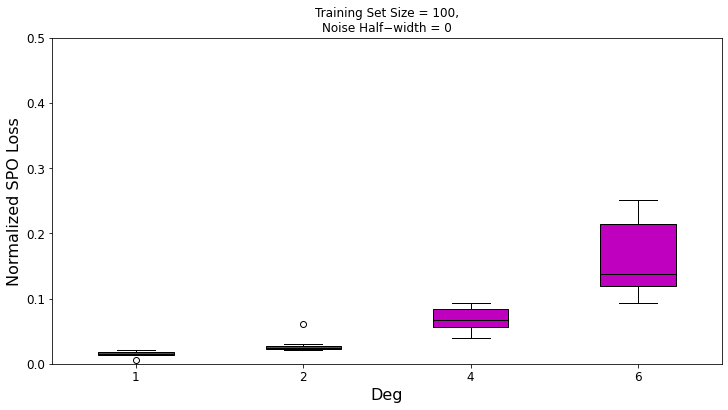

In [9]:
# draw boxplot
plt.figure(figsize=(12,6))
plt.boxplot(df1, boxprops=dict(facecolor='m', color='k'), medianprops=dict(color='k'), patch_artist=True)
plt.xlabel('Deg', fontsize=16)
plt.xticks(ticks=[1,2,3,4], labels=[1,2,4,6], fontsize=12)
plt.ylabel('Normalized SPO Loss', fontsize=16)
plt.yticks(fontsize=12)
plt.ylim(0, 0.5)
plt.title('Training Set Size = 100,\nNoise Half−width = 0')
plt.show()

### Training Set Size = 100, Noise Half−width = 0.5

In [10]:
# set
n = 100 # number of data
p = 5 # size of feature
e = 0.5 # noise half−width
degs = [1, 2, 4, 6] # list of param deg

In [11]:
# init DataFrame
df2 = pd.DataFrame(columns = degs)

In [12]:
for i in range(8):
    row = {}
    for deg in degs:
        # generate data
        x, c = shortestpath.genData(n+1000, p, grid, deg=deg, noise_width=e, seed=i)
        # data split
        x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=i)
        # build data set
        sp_dataset_train = dataset.optDataset(sp_model, x_train, c_train)
        sp_dataset_test = dataset.optDataset(sp_model, x_test, c_test)
        # get data loader
        batch_size = 32
        sp_loader_train = DataLoader(sp_dataset_train, batch_size=batch_size, shuffle=True)
        sp_loader_test = DataLoader(sp_dataset_test, batch_size=batch_size, shuffle=False)
        # train
        learning_rate = 1e-1
        num_epochs = 100
        lr = train(sp_loader_train, sp_model, num_epochs=num_epochs, learning_rate=learning_rate, l1_lambda=1e-3)
        # eval
        loss = unambSPO(lr, sp_model, sp_loader_test)
        print('Normalized SPO Loss: {:.2f}%'.format(loss * 100))
        row[deg] = loss
        print()
    df2 = df2.append(row, ignore_index = True)

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 267.86it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 317.47it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:55<00:00,  1.79it/s]


Normalized SPO Loss: 20.00%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 365.36it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 298.42it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:13<00:00,  1.36it/s]


Normalized SPO Loss: 15.04%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 304.01it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 346.65it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:00<00:00,  1.66it/s]


Normalized SPO Loss: 14.78%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 297.08it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 311.69it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:54<00:00,  1.85it/s]


Normalized SPO Loss: 21.87%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 344.60it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 412.80it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:01<00:00,  1.63it/s]


Normalized SPO Loss: 21.48%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 365.40it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 363.63it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:53<00:00,  1.87it/s]


Normalized SPO Loss: 16.70%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 281.19it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.77it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:01<00:00,  1.63it/s]


Normalized SPO Loss: 19.66%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 342.16it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 395.54it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:00<00:00,  1.65it/s]


Normalized SPO Loss: 22.03%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 376.95it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 349.82it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:52<00:00,  1.89it/s]


Normalized SPO Loss: 21.17%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 404.29it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 302.99it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:06<00:00,  1.51it/s]


Normalized SPO Loss: 17.16%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 268.82it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 283.98it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:10<00:00,  1.41it/s]


Normalized SPO Loss: 19.25%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 348.13it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 302.29it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:03<00:00,  1.58it/s]


Normalized SPO Loss: 22.78%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 344.56it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 303.02it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:02<00:00,  1.60it/s]


Normalized SPO Loss: 20.77%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 398.65it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 384.66it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:58<00:00,  1.71it/s]


Normalized SPO Loss: 18.48%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 366.21it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 398.23it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:57<00:00,  1.75it/s]


Normalized SPO Loss: 19.19%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 369.99it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 372.24it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:59<00:00,  1.67it/s]


Normalized SPO Loss: 23.47%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 261.96it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 314.35it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:58<00:00,  1.70it/s]


Normalized SPO Loss: 22.41%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 295.77it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 332.11it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:58<00:00,  1.72it/s]


Normalized SPO Loss: 17.23%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 298.64it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 361.39it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:00<00:00,  1.65it/s]


Normalized SPO Loss: 17.08%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 328.75it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 304.85it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.77it/s]


Normalized SPO Loss: 18.02%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 306.07it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 348.79it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:59<00:00,  1.67it/s]


Normalized SPO Loss: 21.56%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 386.09it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 367.99it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:59<00:00,  1.67it/s]


Normalized SPO Loss: 17.51%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 362.73it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 378.80it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.79it/s]


Normalized SPO Loss: 23.79%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 414.39it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 294.07it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:00<00:00,  1.66it/s]


Normalized SPO Loss: 22.79%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 387.21it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 372.86it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [01:01<00:00,  1.64it/s]


Normalized SPO Loss: 21.84%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 398.66it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 345.93it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.78it/s]


Normalized SPO Loss: 20.99%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 379.54it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 392.62it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:59<00:00,  1.69it/s]


Normalized SPO Loss: 17.63%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 315.23it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 295.73it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:54<00:00,  1.83it/s]


Normalized SPO Loss: 20.11%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 360.93it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.52it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:59<00:00,  1.69it/s]


Normalized SPO Loss: 20.08%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 418.64it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 366.07it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:59<00:00,  1.69it/s]


Normalized SPO Loss: 17.41%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 432.16it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 348.35it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.78it/s]


Normalized SPO Loss: 17.21%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 381.53it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 317.56it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:59<00:00,  1.68it/s]


Normalized SPO Loss: 14.81%



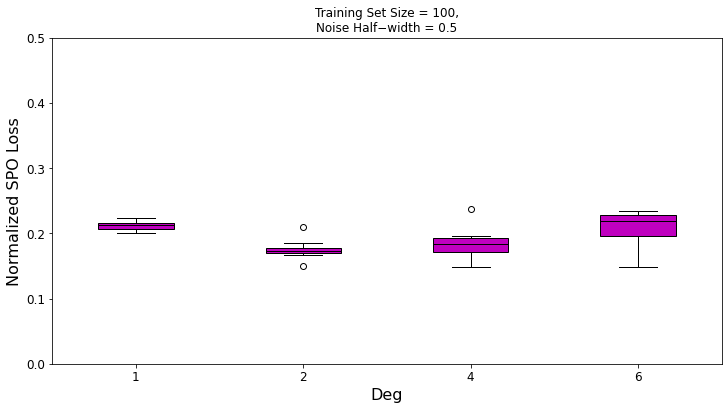

In [13]:
# draw boxplot
plt.figure(figsize=(12,6))
plt.boxplot(df2, boxprops=dict(facecolor='m', color='k'), medianprops=dict(color='k'), patch_artist=True)
plt.xlabel('Deg', fontsize=16)
plt.xticks(ticks=[1,2,3,4], labels=[1,2,4,6], fontsize=12)
plt.ylabel('Normalized SPO Loss', fontsize=16)
plt.yticks(fontsize=12)
plt.ylim(0, 0.5)
plt.title('Training Set Size = 100,\nNoise Half−width = 0.5')
plt.show()

### Training Set Size = 1000, Noise Half−width = 0 

In [14]:
# set
n = 1000 # number of data
p = 5 # size of feature
e = 0 # noise half−width
degs = [1, 2, 4, 6] # list of param deg

In [15]:
# init DataFrame
df3 = pd.DataFrame(columns = degs)

In [16]:
for i in range(8):
    row = {}
    for deg in degs:
        # generate data
        x, c = shortestpath.genData(n+1000, p, grid, deg=deg, noise_width=e, seed=i)
        # data split
        x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=i)
        # build data set
        sp_dataset_train = dataset.optDataset(sp_model, x_train, c_train)
        sp_dataset_test = dataset.optDataset(sp_model, x_test, c_test)
        # get data loader
        batch_size = 32
        sp_loader_train = DataLoader(sp_dataset_train, batch_size=batch_size, shuffle=True)
        sp_loader_test = DataLoader(sp_dataset_test, batch_size=batch_size, shuffle=False)
        # train
        learning_rate = 1e-1
        num_epochs = 30
        lr = train(sp_loader_train, sp_model, num_epochs=num_epochs, learning_rate=learning_rate, l1_lambda=1e-3)
        # eval
        loss = unambSPO(lr, sp_model, sp_loader_test)
        print('Normalized SPO Loss: {:.2f}%'.format(loss * 100))
        row[deg] = loss
        print()
    df3 = df3.append(row, ignore_index = True)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 320.92it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 302.25it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:55<00:00,  5.84s/it]


Normalized SPO Loss: 0.80%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 306.29it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 337.59it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:54<00:00,  5.82s/it]


Normalized SPO Loss: 3.42%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 433.67it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 386.88it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:54<00:00,  5.81s/it]


Normalized SPO Loss: 5.97%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 350.03it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 311.56it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:50<00:00,  5.70s/it]


Normalized SPO Loss: 13.11%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 268.57it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.50it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:53<00:00,  5.79s/it]


Normalized SPO Loss: 0.74%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 372.77it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.82it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:53<00:00,  5.78s/it]


Normalized SPO Loss: 2.88%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 353.18it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 367.46it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [03:12<00:00,  6.43s/it]


Normalized SPO Loss: 5.77%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 284.14it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 288.87it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:36<00:00,  5.20s/it]


Normalized SPO Loss: 14.57%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 363.14it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 354.78it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:24<00:00,  4.81s/it]


Normalized SPO Loss: 1.27%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 436.19it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 438.59it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:24<00:00,  4.81s/it]


Normalized SPO Loss: 1.53%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 367.51it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 428.84it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:25<00:00,  4.85s/it]


Normalized SPO Loss: 3.79%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 367.12it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 389.85it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:28<00:00,  4.93s/it]


Normalized SPO Loss: 13.06%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 369.20it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 376.96it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:27<00:00,  4.91s/it]


Normalized SPO Loss: 1.05%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 410.57it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 421.70it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:25<00:00,  4.86s/it]


Normalized SPO Loss: 2.05%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 356.80it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 438.70it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:24<00:00,  4.81s/it]


Normalized SPO Loss: 5.58%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 434.55it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 403.90it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:29<00:00,  4.98s/it]


Normalized SPO Loss: 11.27%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 433.55it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 419.91it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:26<00:00,  4.87s/it]


Normalized SPO Loss: 0.98%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 432.34it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 429.39it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:26<00:00,  4.89s/it]


Normalized SPO Loss: 2.31%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 351.16it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 365.26it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:24<00:00,  4.81s/it]


Normalized SPO Loss: 3.58%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 388.13it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 361.57it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:25<00:00,  4.86s/it]


Normalized SPO Loss: 15.32%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 432.95it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 430.25it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:23<00:00,  4.77s/it]


Normalized SPO Loss: 0.84%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 369.04it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 428.27it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:24<00:00,  4.82s/it]


Normalized SPO Loss: 2.83%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 364.28it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 369.72it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:29<00:00,  4.99s/it]


Normalized SPO Loss: 4.50%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 425.59it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 410.71it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:25<00:00,  4.86s/it]


Normalized SPO Loss: 10.77%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 455.85it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 424.30it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:24<00:00,  4.82s/it]


Normalized SPO Loss: 1.26%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 416.04it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 443.11it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:24<00:00,  4.81s/it]


Normalized SPO Loss: 2.33%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 430.45it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 435.65it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:27<00:00,  4.91s/it]


Normalized SPO Loss: 12.86%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 427.05it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 423.35it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:28<00:00,  4.96s/it]


Normalized SPO Loss: 16.37%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 439.39it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 431.39it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:35<00:00,  5.18s/it]


Normalized SPO Loss: 1.24%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 390.29it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 390.30it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:19<00:00,  4.65s/it]


Normalized SPO Loss: 2.30%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 459.94it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 458.14it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:18<00:00,  4.60s/it]


Normalized SPO Loss: 3.82%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 451.86it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 397.57it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:16<00:00,  4.56s/it]


Normalized SPO Loss: 9.27%



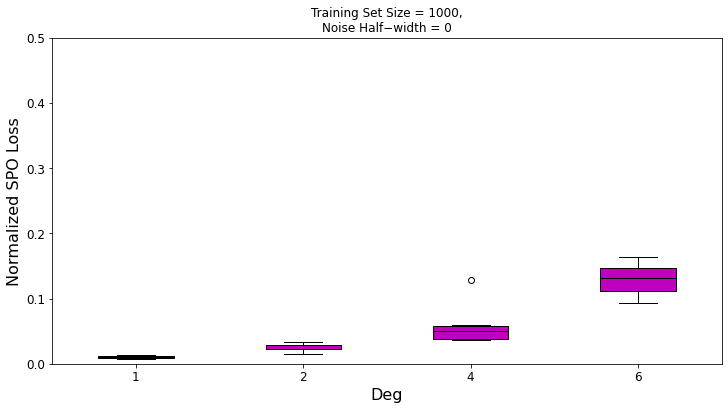

In [17]:
# draw boxplot
plt.figure(figsize=(12,6))
plt.boxplot(df3, boxprops=dict(facecolor='m', color='k'), medianprops=dict(color='k'), patch_artist=True)
plt.xlabel('Deg', fontsize=16)
plt.xticks(ticks=[1,2,3,4], labels=[1,2,4,6], fontsize=12)
plt.ylabel('Normalized SPO Loss', fontsize=16)
plt.yticks(fontsize=12)
plt.ylim(0, 0.5)
plt.title('Training Set Size = 1000,\nNoise Half−width = 0')
plt.show()

### Training Set Size = 1000, Noise Half−width = 0.5 

In [18]:
# set
n = 1000 # number of data
p = 5 # size of feature
e = 0.5 # noise half−width
degs = [1, 2, 4, 6] # list of param deg

In [19]:
# init DataFrame
df4 = pd.DataFrame(columns = degs)

In [20]:
for i in range(8):
    row = {}
    for deg in degs:
        # generate data
        x, c = shortestpath.genData(n+1000, p, grid, deg=deg, noise_width=e, seed=i)
        # data split
        x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=i)
        # build data set
        sp_dataset_train = dataset.optDataset(sp_model, x_train, c_train)
        sp_dataset_test = dataset.optDataset(sp_model, x_test, c_test)
        # get data loader
        batch_size = 32
        sp_loader_train = DataLoader(sp_dataset_train, batch_size=batch_size, shuffle=True)
        sp_loader_test = DataLoader(sp_dataset_test, batch_size=batch_size, shuffle=False)
        # train
        learning_rate = 1e-1
        num_epochs = 30
        lr = train(sp_loader_train, sp_model, num_epochs=num_epochs, learning_rate=learning_rate, l1_lambda=1e-3)
        # eval
        loss = unambSPO(lr, sp_model, sp_loader_test)
        print('Normalized SPO Loss: {:.2f}%'.format(loss * 100))
        row[deg] = loss
        print()
    df4 = df4.append(row, ignore_index = True)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 451.25it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 460.15it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:16<00:00,  4.55s/it]


Normalized SPO Loss: 22.39%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 465.49it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 459.94it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:18<00:00,  4.61s/it]


Normalized SPO Loss: 16.92%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 384.31it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 381.24it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:18<00:00,  4.61s/it]


Normalized SPO Loss: 15.58%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 413.64it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 440.93it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:27<00:00,  4.93s/it]


Normalized SPO Loss: 18.98%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 425.76it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 459.94it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:20<00:00,  4.68s/it]


Normalized SPO Loss: 21.22%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 381.10it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 358.35it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:22<00:00,  4.74s/it]


Normalized SPO Loss: 19.89%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 398.83it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 441.51it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:21<00:00,  4.71s/it]


Normalized SPO Loss: 14.72%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 458.05it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 443.66it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:23<00:00,  4.80s/it]


Normalized SPO Loss: 15.04%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 366.34it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 375.81it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:19<00:00,  4.67s/it]


Normalized SPO Loss: 20.83%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 438.23it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 454.72it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:26<00:00,  4.89s/it]


Normalized SPO Loss: 19.45%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 449.02it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 463.34it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:17<00:00,  4.57s/it]


Normalized SPO Loss: 15.09%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 463.13it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 377.51it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:19<00:00,  4.65s/it]


Normalized SPO Loss: 20.66%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 444.05it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 451.86it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:15<00:00,  4.51s/it]


Normalized SPO Loss: 23.06%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 454.93it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 453.90it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:20<00:00,  4.69s/it]


Normalized SPO Loss: 17.70%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 455.97it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 468.76it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:15<00:00,  4.53s/it]


Normalized SPO Loss: 17.30%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 388.78it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 428.68it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:19<00:00,  4.66s/it]


Normalized SPO Loss: 17.88%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 452.27it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 470.30it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:16<00:00,  4.54s/it]


Normalized SPO Loss: 21.29%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 454.72it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 451.45it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:17<00:00,  4.60s/it]


Normalized SPO Loss: 16.35%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 432.01it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 401.39it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:18<00:00,  4.61s/it]


Normalized SPO Loss: 15.96%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 173.09it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.01it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:42<00:00,  5.42s/it]


Normalized SPO Loss: 19.61%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 425.24it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 441.54it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:23<00:00,  4.79s/it]


Normalized SPO Loss: 21.66%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 439.00it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 434.05it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:24<00:00,  4.83s/it]


Normalized SPO Loss: 15.88%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 421.02it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 443.23it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:26<00:00,  4.89s/it]


Normalized SPO Loss: 17.96%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 435.36it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 442.99it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:25<00:00,  4.86s/it]


Normalized SPO Loss: 25.93%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 434.38it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 432.85it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:26<00:00,  4.90s/it]


Normalized SPO Loss: 20.88%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 434.10it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 433.10it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:26<00:00,  4.89s/it]


Normalized SPO Loss: 16.30%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 435.93it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 435.23it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:26<00:00,  4.89s/it]


Normalized SPO Loss: 12.71%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 366.48it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 361.95it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:26<00:00,  4.87s/it]


Normalized SPO Loss: 28.03%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 377.43it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 350.04it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:25<00:00,  4.84s/it]


Normalized SPO Loss: 19.27%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 404.79it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 346.87it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:25<00:00,  4.86s/it]


Normalized SPO Loss: 16.59%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 383.41it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 376.11it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:25<00:00,  4.84s/it]


Normalized SPO Loss: 14.03%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 388.10it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 401.97it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:26<00:00,  4.87s/it]


Normalized SPO Loss: 17.65%



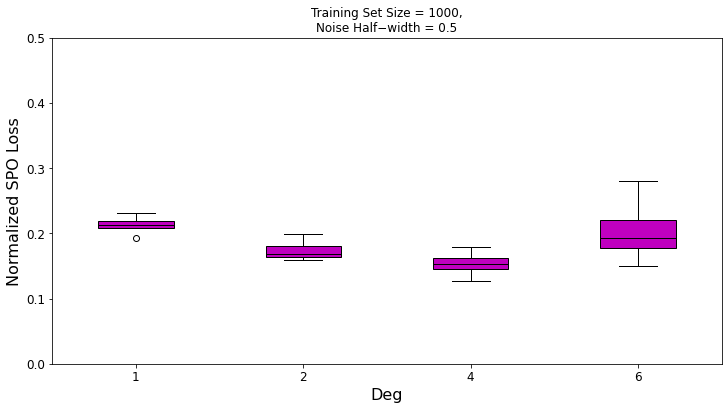

In [21]:
# draw boxplot
plt.figure(figsize=(12,6))
plt.boxplot(df4, boxprops=dict(facecolor='m', color='k'), medianprops=dict(color='k'), patch_artist=True)
plt.xlabel('Deg', fontsize=16)
plt.xticks(ticks=[1,2,3,4], labels=[1,2,4,6], fontsize=12)
plt.ylabel('Normalized SPO Loss', fontsize=16)
plt.yticks(fontsize=12)
plt.ylim(0, 0.5)
plt.title('Training Set Size = 1000,\nNoise Half−width = 0.5')
plt.show()

## Save File 

In [22]:
df1.to_csv('./res/blackbox_n100.csv', index=False)
df2.to_csv('./res/blackbox_n100_noise.csv', index=False)
df3.to_csv('./res/blackbox_n1000.csv', index=False)
df4.to_csv('./res/blackbox_n1000_noise.csv', index=False)